# Mixology
v0.1

## Environment Setup

In [21]:
%load_ext autoreload
%autoreload 2

import os
import typedb
import pickle
import copy
import azlib.utils as azutils

import networkx as nx
import networkx.algorithms.isomorphism as iso
import pandas as pd
import azlib.queries as azq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from collections import Counter
from collections import defaultdict
from tqdm import tqdm
from typedb.client import *
from typing import List, Dict
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from azlib.utils import get_id_name_map
from azlib.utils import sort_graph_nodes
from kglib.utils.graph.query.query_graph import QueryGraphAZ
from kglib.utils.graph.thing.queries_to_networkx_graph import build_graph_from_queries

# configs
DATABASE = "orbit"
ADDRESS = "localhost:1729"
REBUILD_INGREDIENT_NPMI_PICKLES = False
RESAMPLE_METAPATHS = False
METAPATH_PKL_FILES = ['graphs_fcncf.pkl', 'graphs_ncfcn.pkl']
# METAPATH_PKL_FILES = ['graphs_all.pkl']

client = TypeDB.core_client(ADDRESS)
session = client.session(DATABASE, SessionType.DATA)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [2]:
if RESAMPLE_METAPATHS:
    # rebuild the following pkl files:
    #   - graphs_fcncf.pkl
    #   - graphs_ncfcn.pkl
    #   - graphs_nncfcnn.pkl
    !python 'sample_metapaths.py'
    
if REBUILD_INGREDIENT_NPMI_PICKLES:
    # rebuild the following pkl files:
    #   - compound_ingredients.pkl
    #   - non_compound_ingredients.pkl
    #   - npmi_pair_scores.pkl
    pwd = os.path.dirname(os.path.realpath("__file__"))
    azutils.rebuild_pkls(pwd=pwd)

In [3]:
# load id_to_name mapping
print('Loading id_to_name mapping...')
map_c_id_to_name, map_n_id_to_name, map_f_id_to_name = get_id_name_map(session, 'id_to_name', True, 0)
map_id_to_name = defaultdict(lambda: None)
map_id_to_name.update(map_c_id_to_name)
map_id_to_name.update(map_n_id_to_name)
map_id_to_name.update(map_f_id_to_name)

# load name_to_id mapping
print('')
print('Loading name_to_id mapping...')
map_c_name_to_id, map_n_name_to_id, map_f_name_to_id = get_id_name_map(session, 'name_to_id', True, 0)
map_name_to_id = defaultdict(lambda: None)
map_name_to_id.update(map_c_name_to_id)
map_name_to_id.update(map_n_name_to_id)
map_name_to_id.update(map_f_name_to_id)

# load training set
print('')
print('Loading training dataset...')
graphs = []
pwd = os.path.dirname(os.path.realpath("__file__"))
for pkl_file in METAPATH_PKL_FILES:
    with open(f"{pwd}/data/{pkl_file}", "rb") as f:
        graphs.extend(pickle.load(f))
print('Completed!')

Loading id_to_name mapping...
Compound-Ingredient Total Count: 46
Non-Ingredient Total Count: 285
Flavor-Compound Total Count: 1118

Duplicate Compound-Ingredient Count: 1072
Duplicate Non-Ingredient Count: 0
Duplicate Flavor-Compound Count: 0

Loading name_to_id mapping...
Compound-Ingredient Total Count: 46
Non-Ingredient Total Count: 285
Flavor-Compound Total Count: 1118

Duplicate Compound-Ingredient Count: 0
Duplicate Non-Ingredient Count: 0
Duplicate Flavor-Compound Count: 0

Loading training dataset...
Completed!


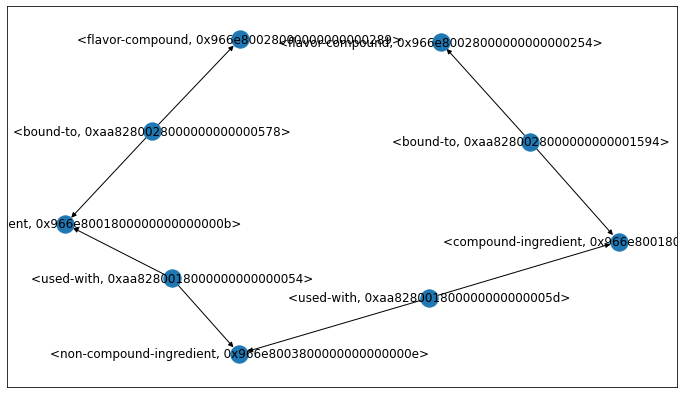

In [4]:
g = copy.deepcopy(graphs[0])
plt.figure(figsize=(12,7)) 
nx.draw_networkx(g, with_labels=True)

In [5]:
VERBOSE = False

# extract nodes in order from nextworkx meta-path instances
nodes_paths = []
for i, graph in tqdm(enumerate(graphs), total=len(graphs)):
    # str(graph) gives the name of the first node in the graph
    seed_node_id = map_name_to_id[str(graph)]
    if not seed_node_id:
        print(f'Warning: Missing mapping for "{str(graph)}", index = {i}...')
    else:
        if VERBOSE:
            print(f'Extracting {graph}...')
        nodes_paths.append(sort_graph_nodes(graph, seed_node_id, map_id_to_name))

print(f'Total number of paths extracted: {len(nodes_paths)}')

100%|██████████| 64896/64896 [01:49<00:00, 592.55it/s]

Total number of paths extracted: 64896


## EDA

In [8]:
# extract ingredient counts
node_counter = Counter([node for path in nodes_paths for node in path])
ingredients_dict = {}
for key, val in node_counter.items():
    if key not in map_f_name_to_id.keys():
        ingredients_dict[key] = val
sorted_ingredients_dict = {k: v for k, v in sorted(ingredients_dict.items(), key=lambda item: item[1])}

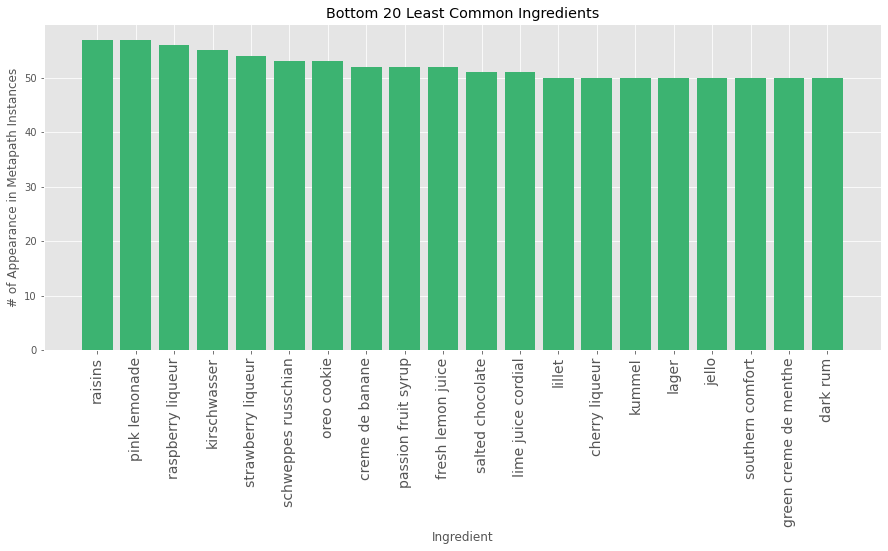

In [9]:
RANKS = 20
x_axis = list(sorted_ingredients_dict.keys())[:RANKS]
y_axis = list(sorted_ingredients_dict.values())[:RANKS]
x_pos = [i for i, _ in enumerate(x_axis)]

plt.style.use('ggplot')
plt.figure(figsize=(15, 6))
plt.bar(x_axis[::-1], y_axis[::-1], color='mediumseagreen')
plt.xlabel("Ingredient")
plt.ylabel("# of Appearance in Metapath Instances")
plt.title(f"Bottom {RANKS} Least Common Ingredients")
plt.xticks(x_pos, x_axis, fontsize=14, rotation=90)

plt.show()
pass

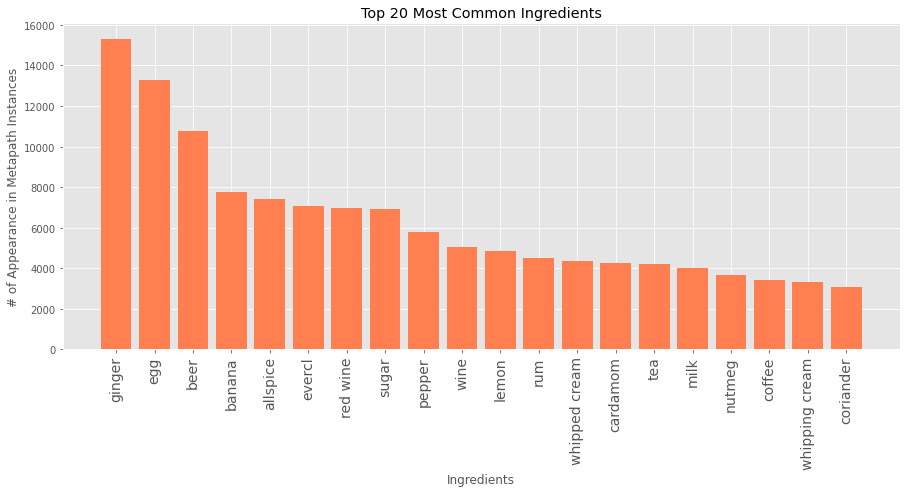

In [10]:
RANKS = 20
x_axis = list(sorted_ingredients_dict.keys())[-RANKS:]
y_axis = list(sorted_ingredients_dict.values())[-RANKS:]
x_pos = [i for i, _ in enumerate(x_axis)]

plt.style.use('ggplot')
plt.figure(figsize=(15, 6))
plt.bar(x_axis[::-1], y_axis[::-1], color='coral')
plt.xlabel("Ingredients")
plt.ylabel("# of Appearance in Metapath Instances")
plt.title(f"Top {RANKS} Most Common Ingredients")
plt.xticks(x_pos, x_axis, fontsize=14, rotation=90)

plt.show()
pass

## Training

In [11]:
SAVE_MOEL = False

# train the skip-gram
print('Training Word2Vec...')
model = Word2Vec(
            sentences=nodes_paths, 
            epochs=10, 
            vector_size=100, 
            window=5, 
            min_count=0, 
            sg=1, 
            workers=2)
if SAVE_MOEL:
    pwd = os.path.dirname(os.path.realpath('__file__'))
    save_path = f'{pwd}/models/word2vec.wordvectors' 
    model.save(save_path)
    print(f'Model saved to {save_path}...')

# retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

print('Complete!')

Training Word2Vec...
Complete!


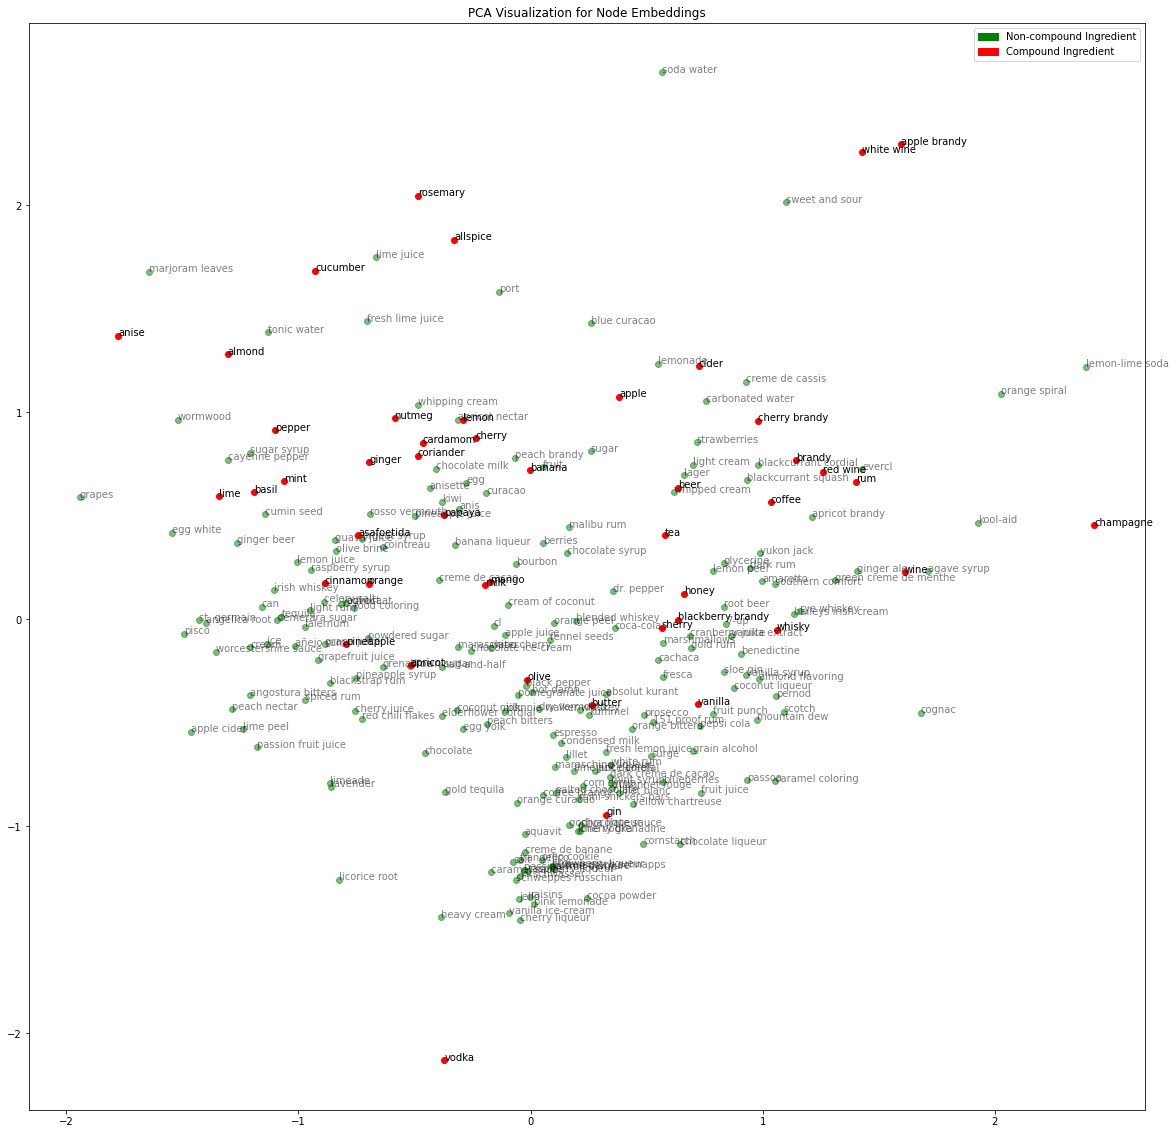

In [7]:
model_ingredient_names, model_ingredient_vectors, node_count_compound_ingred = \
    azutils.get_model_ingredient_vectors_names(
        model = model, 
        map_c_id_to_name=map_c_id_to_name, 
        map_n_id_to_name=map_n_id_to_name, 
        verbose=False
    )

# dim reduction for plotting
transform = PCA  # PCA or TSNE
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(model_ingredient_vectors)
    
def plot_ingredients(*args, **kwargs) -> None:
    """Proxy function to azutils.plot_ingredients. This is just a quick "hack" so 
    we don't have to repeated enter the same arguments. 
    """
    azutils.plot_ingredients(
        transform_name               = transform.__name__,
        node_embeddings_2d           = node_embeddings_2d,
        node_names                   = np.array(model_ingredient_names),
        indice_non_compound_ingred   = (node_count_compound_ingred, None),
        indice_compound_ingred       = (0, node_count_compound_ingred),
        **kwargs
    )

plot_ingredients(fig_size=(20, 20))

## Distance Analysis

### Pairing by Cosine Distance

In [41]:
INGREDIENTS = ["ice", "rum"]
# INGREDIENTS = ["egg"]

pairings, scores = azutils.find_pairings_by_cos(
                                        INGREDIENTS, 
                                        model, 
                                        model_ingredient_names, 
                                        top_n_pairings=10)
results_df = pd.DataFrame({'Ingredient': pairings, 'Cosine Distance': scores})
print(f'Ingredient(s): {INGREDIENTS}')
print(results_df)

Ingredient(s): ['ice', 'rum']
        Ingredient  Cosine Distance
0             maui         0.546270
1      fruit punch         0.538927
2       grape soda         0.532827
3     pisang ambon         0.531100
4      cranberries         0.530011
5         vermouth         0.527244
6     blackberries         0.524717
7       cornstarch         0.517942
8       triple sec         0.516975
9  cranberry vodka         0.514708


### Pairing by NPMI

In [46]:
INGREDIENT = "milk"

# load the npmi scores for all ingredient-ingredient pairs from the migrators
npmi_pair_scores, _ = azutils.get_npmi_pairs()
top_n_pairings, paired_ingredients = azutils.recipe_based_pairings(INGREDIENT, 10, npmi_pair_scores)

# print top_n results
results_df = pd.DataFrame({'Ingredient': top_n_pairings.keys(), 'NPMI Score': top_n_pairings.values()})
print(f'Ingredient: {INGREDIENT}')
print(results_df)

Ingredient: milk
              Ingredient  NPMI Score
0              chocolate    0.558866
1         godiva liqueur    0.539290
2  butterscotch schnapps    0.484697
3        vanilla extract    0.451522
4             mint syrup    0.446254
5           black pepper    0.446254
6          caramel sauce    0.446254
7             cornstarch    0.446254
8     mini-snickers bars    0.446254
9           cocoa powder    0.442351


### Pairing Cosine Distance vs. NPMI

Ingredient(s): coffee
          Ingredient  Cosine Distance  NPMI Score
0        irish cream         0.371028         NaN
1   caramel coloring         0.362631    0.482453
2     guinness stout         0.355769         NaN
3       jack daniels         0.350979    0.264762
4    pina colada mix         0.343992         NaN
5      bacardi limon         0.334788         NaN
6           drambuie         0.331771         NaN
7             evercl         0.330863    0.264762
8       daiquiri mix         0.321749         NaN
9               wine         0.321159         NaN
10      jägermeister         0.319004         NaN


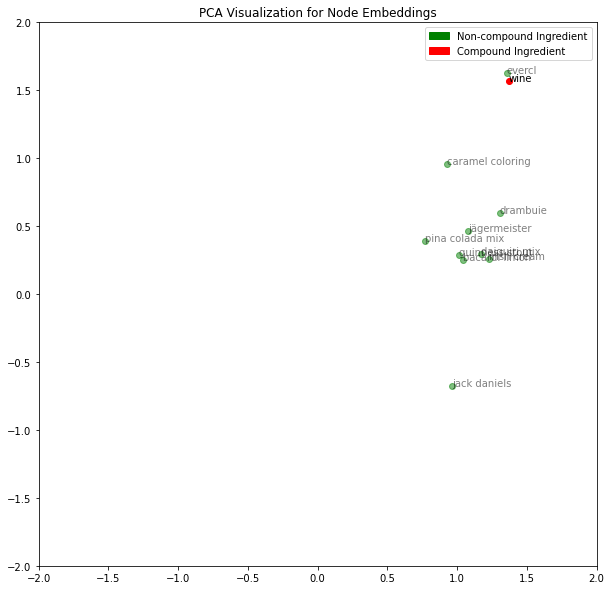

In [82]:
INGREDIENT = "coffee"

# load cosine
paired_ingredients, cos_scores = azutils.find_pairings_by_cos(
                                        [INGREDIENT], 
                                        model, 
                                        model_ingredient_names, 
                                        top_n_pairings=10)

# load npmi
paired_ingredients_npmi_dict = azutils.load_npmi_scores(INGREDIENT, paired_ingredients)

# print report
results_df = pd.DataFrame({
                'Ingredient': paired_ingredients, 
                'Cosine Distance': cos_scores, 
                'NPMI Score': paired_ingredients_npmi_dict.values()
            })
print(f'Ingredient(s): {INGREDIENT}')
print(results_df)

# plot ingredients
ingredient_names = [INGREDIENT]
ingredient_names.extend(paired_ingredients)
if transform.__name__ == 'TSNE':
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-20, 20))
else:
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-2, 2))